# Importing Modules

In [149]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns 
import datetime as dt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


# Importing Data

In [150]:
df = pd.read_csv("../Data/Preprocessed/preprocessed_railway.csv")

# Preprocessing

In [151]:
df = df.fillna(value={'Railcard': 'No Railcard'})

In [152]:
df["Departure Date"] = pd.to_datetime(df["Departure Date"], errors="coerce")
df['Departure Date'] = pd.to_datetime(df['Departure Date'].dt.date) # Departure Date with no Timestamps

# Feature Engineering

In [153]:
daily = df.groupby('Departure Date').agg(
    Rides=('Transaction ID', 'count'), 
    Revenue=('Price', 'sum')          
).reset_index()

daily = daily.sort_values('Departure Date')

daily['DayNumber'] = (daily['Departure Date'] - daily['Departure Date'].min()).dt.days

daily.head()

,Departure Date,Rides,Revenue,DayNumber
0,2024-01-01,66,1682,0
1,2024-01-02,146,4830,1
2,2024-01-03,292,7159,2
3,2024-01-04,274,7063,3
4,2024-01-05,253,5934,4


In [154]:
# Feature engineering for 'daily' DataFrame
daily = daily.sort_values('Departure Date').reset_index(drop=True)

# basic date features
daily['dayofweek'] = daily['Departure Date'].dt.dayofweek           # 0 = Mon
daily['is_weekend'] = daily['dayofweek'].isin([5,6]).astype(int)

# lag features for rides and revenue
for lag in [1,2,3,7,14]:
    daily[f'rides_lag_{lag}'] = daily['Rides'].shift(lag)
    daily[f'rev_lag_{lag}'] = daily['Revenue'].shift(lag)

# rolling means
daily['rides_roll_7'] = daily['Rides'].rolling(7, min_periods=1).mean().shift(1)
daily['revenue_roll_7'] = daily['Revenue'].rolling(7, min_periods=1).mean().shift(1)

# one-hot for dayofweek (optional for tree models you can skip)
dummies = pd.get_dummies(daily['dayofweek'], prefix='dow', drop_first=False)
daily = pd.concat([daily, dummies], axis=1)

# drop rows with NA from introduced lags
daily_fe = daily.dropna().reset_index(drop=True)
daily_fe.head()


,Departure Date,Rides,Revenue,DayNumber,dayofweek,is_weekend,rides_lag_1,rev_lag_1,rides_lag_2,rev_lag_2,...,rev_lag_14,rides_roll_7,revenue_roll_7,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6
0,2024-01-15,250,6530,14,0,0,265.0,6007.0,275.0,5871.0,...,1682.0,275.714286,6678.857143,True,False,False,False,False,False,False
1,2024-01-16,273,6227,15,1,0,250.0,6530.0,265.0,6007.0,...,4830.0,270.142857,6649.285714,False,True,False,False,False,False,False
2,2024-01-17,293,7028,16,2,0,273.0,6227.0,250.0,6530.0,...,7159.0,271.142857,6487.571429,False,False,True,False,False,False,False
3,2024-01-18,301,7279,17,3,0,293.0,7028.0,273.0,6227.0,...,7063.0,274.714286,6540.857143,False,False,False,True,False,False,False
4,2024-01-19,274,7420,18,4,0,301.0,7279.0,293.0,7028.0,...,5934.0,276.285714,6522.857143,False,False,False,False,True,False,False


# Linear Regression Model Training

In [155]:
X = daily[['DayNumber']]
y = daily['Rides']      

model = LinearRegression()

model.fit(X, y)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


# Linear Regression Model Evaluation

In [156]:
features = ['dayofweek','is_weekend','rides_lag_1','rides_lag_7','rides_roll_7'] + [f'dow_{i}' for i in range(7)]

X = daily_fe[features]
y = daily_fe['Rides']

# Split; Last 30 days as test (time series holdout)
train = daily_fe.iloc[:-30]
test = daily_fe.iloc[-30:]
X_train, y_train = train[features], train['Rides']
X_test, y_test = test[features], test['Rides']

# train LinearRegression
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Linear Regression on Rides - MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)


Linear Regression on Rides - MAE: 26.79694666380104
RMSE: 44.2464369282585
R2: 0.05482149807140768


# RandomForestRegressor Model Evaluation

In [157]:

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("RF - MAE:", mae_rf)
print("RF - RMSE:", rmse_rf)
print("RF - R2:", r2_rf)


RF - MAE: 22.100666666666665
RF - RMSE: 40.18907115124708
RF - R2: 0.22021807250308312


In [158]:
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)


,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [159]:
y_pred_rf = rf.predict(X_test)


In [160]:
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print("RF - MAE:", mae_rf)
print("RF - RMSE:", rmse_rf)
print("RF - R2:", r2_rf)


RF - MAE: 22.100666666666665
RF - RMSE: 40.18907115124708
RF - R2: 0.22021807250308312


In [161]:
features = ['dayofweek','is_weekend','rides_lag_1','rides_lag_7','rides_roll_7'] + [f'dow_{i}' for i in range(7)]

future_dates = pd.date_range(daily['Departure Date'].max() + pd.Timedelta(days=1), periods=30)
future_df = pd.DataFrame({'Departure Date': future_dates})

future_rides = []

# Evaluate from the last days i the current dats
lag_1 = daily_fe['Rides'].iloc[-1]
lag_7 = daily_fe['Rides'].iloc[-7]
roll_7 = daily_fe['rides_roll_7'].iloc[-1]

for i, day in enumerate(future_dates):
    dayofweek = day.dayofweek
    is_weekend = 1 if dayofweek >= 5 else 0
    dow_features = [1 if dayofweek == d else 0 for d in range(7)]
    
    # Dataframe with the same columns used for training
    X = pd.DataFrame([[dayofweek, is_weekend, lag_1, lag_7, roll_7] + dow_features],
                     columns=features)
    
    # Passeger Number Prediction
    pred = rf.predict(X)[0]
    future_rides.append(pred)
    
    # Update Evaluation for the next day
    lag_1 = pred
    lag_7 = future_rides[i-7] if i >= 7 else lag_7
    roll_7 = np.mean(future_rides[max(0, i-6):i+1])


In [162]:
forecast_df = pd.DataFrame({
    'Departure Date': future_dates,
    'Predicted Rides': future_rides
})


# Rides Predictions


### Average predicted rides for the next month 

In [163]:
future_dates = pd.date_range(daily['Departure Date'].max() + pd.Timedelta(days=1), periods=30)
future_df = pd.DataFrame({'Departure Date': future_dates})

future_df['dayofweek'] = future_df['Departure Date'].dt.dayofweek
future_df['is_weekend'] = future_df['dayofweek'].isin([5,6]).astype(int)

future_df['rides_lag_1'] = daily_fe['Rides'].iloc[-1]
future_df['rides_lag_7'] = daily_fe['Rides'].iloc[-7]
future_df['rides_roll_7'] = daily_fe['rides_roll_7'].iloc[-1]

for i in range(7):
    future_df[f'dow_{i}'] = (future_df['dayofweek'] == i).astype(int)


features = ['dayofweek','is_weekend','rides_lag_1','rides_lag_7','rides_roll_7'] + [f'dow_{i}' for i in range(7)]
X_future = future_df[features]

predicted_rides = rf.predict(X_future)

forecast_df = pd.DataFrame({
    'Departure Date': future_dates,
    'Predicted Rides': predicted_rides
})
print(forecast_df)


   Departure Date  Predicted Rides
0      2024-05-01          286.075
1      2024-05-02          277.020
2      2024-05-03          272.770
3      2024-05-04          273.900
4      2024-05-05          273.985
5      2024-05-06          268.020
6      2024-05-07          271.945
7      2024-05-08          286.075
8      2024-05-09          277.020
9      2024-05-10          272.770
10     2024-05-11          273.900
11     2024-05-12          273.985
12     2024-05-13          268.020
13     2024-05-14          271.945
14     2024-05-15          286.075
15     2024-05-16          277.020
16     2024-05-17          272.770
17     2024-05-18          273.900
18     2024-05-19          273.985
19     2024-05-20          268.020
20     2024-05-21          271.945
21     2024-05-22          286.075
22     2024-05-23          277.020
23     2024-05-24          272.770
24     2024-05-25          273.900
25     2024-05-26          273.985
26     2024-05-27          268.020
27     2024-05-28   

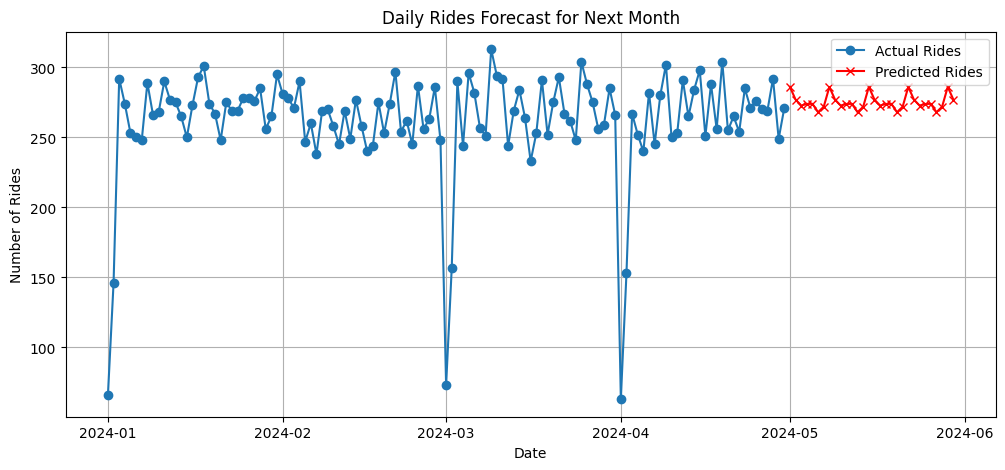

In [164]:
plt.figure(figsize=(12,5))
plt.plot(daily['Departure Date'], daily['Rides'], label='Actual Rides', marker='o')
plt.plot(forecast_df['Departure Date'], forecast_df['Predicted Rides'], label='Predicted Rides', marker='x', color='red')
plt.title("Daily Rides Forecast for Next Month")
plt.xlabel("Date")
plt.ylabel("Number of Rides")
plt.legend()
plt.grid(True)
plt.show()


### Average predicted rides for each week of the next month

   WeekNumber   avg_rides
0          18  276.750000
1          19  274.816429
2          20  274.816429
3          21  274.816429
4          22  275.765000


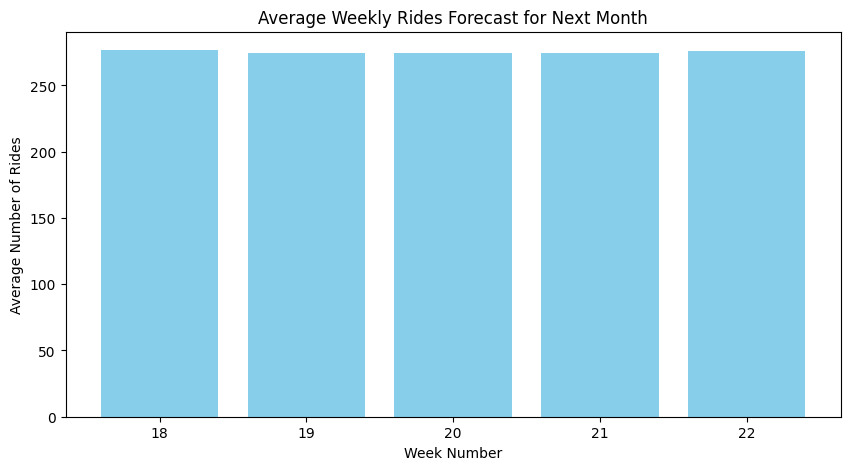

In [165]:
forecast_df['WeekNumber'] = forecast_df['Departure Date'].dt.isocalendar().week

weekly_forecast = forecast_df.groupby('WeekNumber').agg(
    avg_rides=('Predicted Rides', 'mean')
).reset_index()

print(weekly_forecast)

plt.figure(figsize=(10,5))
plt.bar(weekly_forecast['WeekNumber'], weekly_forecast['avg_rides'], color='skyblue')
plt.title("Average Weekly Rides Forecast for Next Month")
plt.xlabel("Week Number")
plt.ylabel("Average Number of Rides")
plt.show()


### Average predicted rides for each day of the week and the highest day

In [166]:
forecast_df['Weekday'] = forecast_df['Departure Date'].dt.day_name()

avg_rides_by_day = forecast_df.groupby('Weekday')['Predicted Rides'].mean().sort_values(ascending=False)

print(avg_rides_by_day)
top_day = avg_rides_by_day.idxmax()  
top_rides = avg_rides_by_day.max()    

print(f"The day expected to have the highest number of rides is {top_day} with an average of {top_rides:.0f} rides.")

Weekday
Wednesday    286.075
Thursday     277.020
Sunday       273.985
Saturday     273.900
Friday       272.770
Tuesday      271.945
Monday       268.020
Name: Predicted Rides, dtype: float64
The day expected to have the highest number of rides is Wednesday with an average of 286 rides.


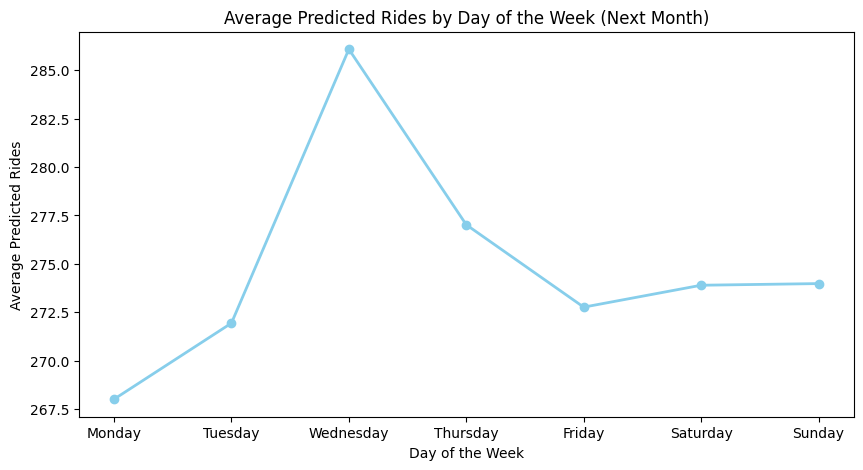

In [167]:

# ترتيب الأيام من Monday إلى Sunday
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
avg_rides_by_day = avg_rides_by_day.reindex(days_order)

# رسم line chart
plt.figure(figsize=(10,5))
plt.plot(avg_rides_by_day.index, avg_rides_by_day.values, marker='o', color='skyblue', linewidth=2)
plt.title("Average Predicted Rides by Day of the Week (Next Month)")
plt.xlabel("Day of the Week")
plt.ylabel("Average Predicted Rides")
plt.show()


# Revenue Predictions

### Daily Revenue

In [168]:
revenue_by_day = df.groupby('Departure Weekday')['Price'].sum()

# ترتيب الأيام من Monday إلى Sunday
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
revenue_by_day = revenue_by_day.reindex(days_order)

print(revenue_by_day)
top_revenue_day = revenue_by_day.idxmax()
top_revenue = revenue_by_day.max()

print(f"The day with the highest revenue is {top_revenue_day} with a total of {top_revenue:.2f}.")



Departure Weekday
Monday       107772
Tuesday      112688
Wednesday    113802
Thursday     105242
Friday       105433
Saturday      96936
Sunday       100048
Name: Price, dtype: int64
The day with the highest revenue is Wednesday with a total of 113802.00.


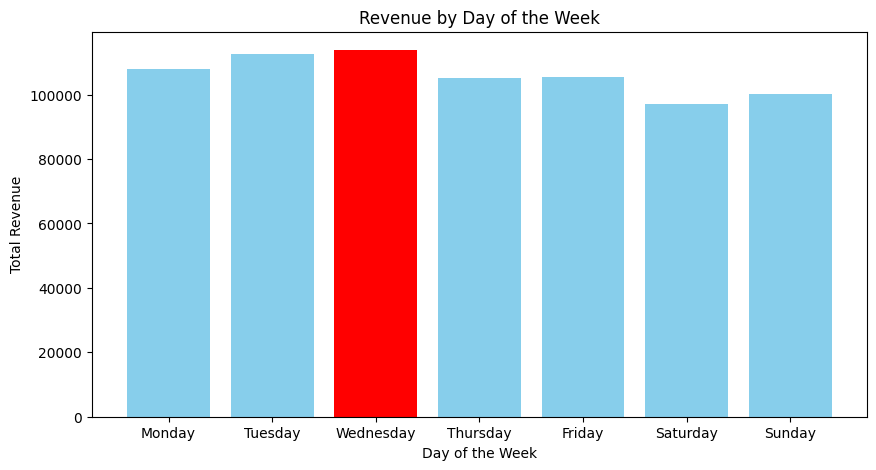

In [169]:
colors = ['red' if day == top_revenue_day else 'skyblue' for day in days_order]

plt.figure(figsize=(10,5))
plt.bar(days_order, revenue_by_day.values, color=colors)
plt.title("Revenue by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Total Revenue")
plt.show()


### Expected Peak Revenue Days for Next Month

In [170]:
daily_demand = df.groupby("Departure Date")["Transaction ID"].count().reset_index()
daily_demand.columns = ["Departure Date", "Rides"]

daily_demand["day"] = daily_demand["Departure Date"].dt.day

threshold = daily_demand["Rides"].quantile(0.85)

peak_days = daily_demand[daily_demand["Rides"] >= threshold]

peak_day_counts = peak_days["day"].value_counts().sort_index()

repeated_peak_days = peak_day_counts[peak_day_counts >= 2].index.tolist()

print("Historical Peak Demand Days:")
print(peak_day_counts)

print("\nExpected Peak Revenue Days for Next Month:")
print(repeated_peak_days)

Historical Peak Demand Days:
day
3     2
4     1
5     1
9     2
10    1
11    2
12    1
15    1
17    1
18    2
19    1
21    2
25    1
28    1
31    1
Name: count, dtype: int64

Expected Peak Revenue Days for Next Month:
[3, 9, 11, 18, 21]


### Revenue Share by Ticket Class

Revenue Contribution by Ticket Class:
Ticket Class
First Class    0.201368
Standard       0.798632
Name: Price, dtype: float64


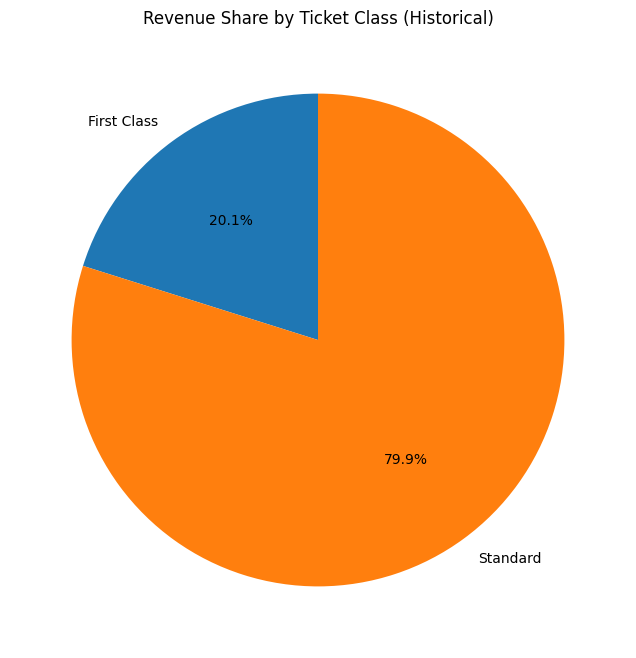


Total Forecasted Revenue Next Month: 193559.86

Forecasted Revenue for Each Ticket Class:
Ticket Class
First Class     38976.723187
Standard       154583.136275
Name: Price, dtype: float64


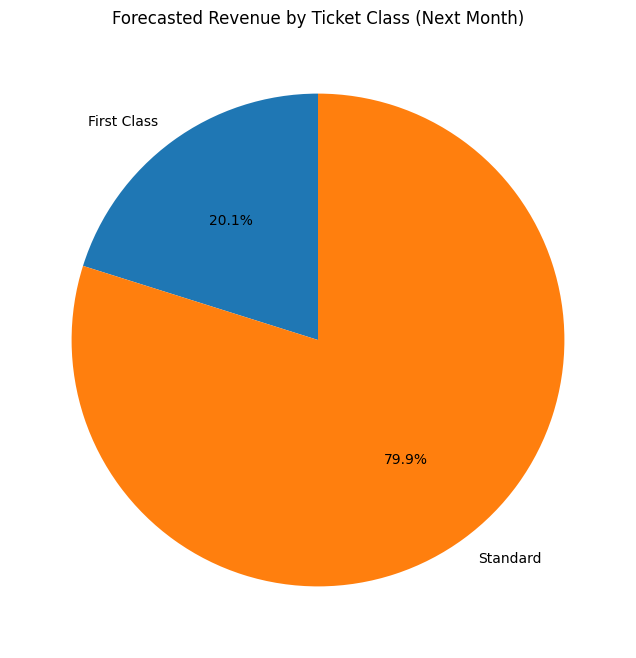

In [171]:
class_revenue = df.groupby('Ticket Class')['Price'].sum()
class_revenue_share = class_revenue / class_revenue.sum()

print("Revenue Contribution by Ticket Class:")
print(class_revenue_share)

plt.figure(figsize=(8,8))
class_revenue_share.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title("Revenue Share by Ticket Class (Historical)")
plt.ylabel("")
plt.show()

avg_ticket_price = df['Price'].mean()
total_predicted_revenue = forecast_df['Predicted Rides'].sum() * avg_ticket_price

print(f"\nTotal Forecasted Revenue Next Month: {total_predicted_revenue:.2f}")

forecasted_revenue_by_class = total_predicted_revenue * class_revenue_share

print("\nForecasted Revenue for Each Ticket Class:")
print(forecasted_revenue_by_class)

plt.figure(figsize=(8,8))
forecasted_revenue_by_class.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title("Forecasted Revenue by Ticket Class (Next Month)")
plt.ylabel("")
plt.show()


### Impact of 5% Ticket Price Increase on Forecasted Revenue

Current Forecasted Revenue: 193559.86
Forecasted Revenue After 5% Price Increase: 203237.85
Additional Revenue Expected: 9677.99
Percentage Increase in Revenue: 5.00%


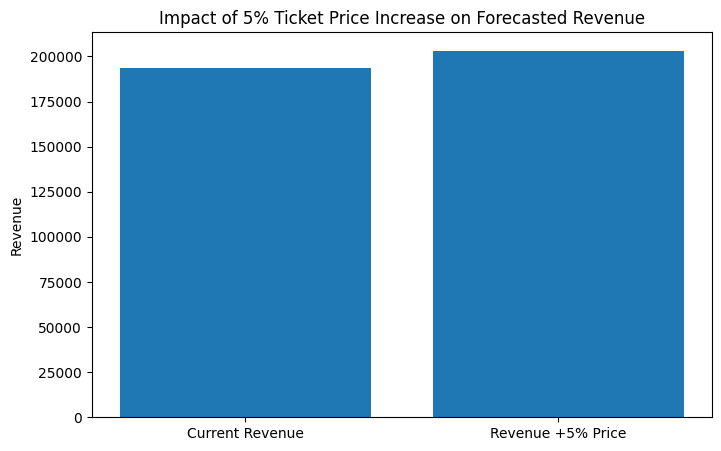

In [172]:
avg_ticket_price = df['Price'].mean()
total_predicted_revenue = forecast_df['Predicted Rides'].sum() * avg_ticket_price

increased_price = avg_ticket_price * 1.05
total_predicted_revenue_after_increase = forecast_df['Predicted Rides'].sum() * increased_price

additional_revenue = total_predicted_revenue_after_increase - total_predicted_revenue
percentage_increase = (additional_revenue / total_predicted_revenue) * 100

print(f"Current Forecasted Revenue: {total_predicted_revenue:.2f}")
print(f"Forecasted Revenue After 5% Price Increase: {total_predicted_revenue_after_increase:.2f}")
print(f"Additional Revenue Expected: {additional_revenue:.2f}")
print(f"Percentage Increase in Revenue: {percentage_increase:.2f}%")


plt.figure(figsize=(8,5))
plt.bar(["Current Revenue", "Revenue +5% Price"], 
        [total_predicted_revenue, total_predicted_revenue_after_increase])
plt.title("Impact of 5% Ticket Price Increase on Forecasted Revenue")
plt.ylabel("Revenue")
plt.show()


### Revenue Impact of Price Increase on Peak Days

Peak Demand Days:
    Departure Date  Rides
2       2024-01-03    292
7       2024-01-08    289
10      2024-01-11    290
16      2024-01-17    293
17      2024-01-18    301
30      2024-01-31    295
34      2024-02-04    290
51      2024-02-21    297
55      2024-02-25    287
58      2024-02-28    286
62      2024-03-03    290
64      2024-03-05    296
68      2024-03-09    313
69      2024-03-10    294
70      2024-03-11    292
77      2024-03-18    291
80      2024-03-21    293
84      2024-03-25    304
85      2024-03-26    288
99      2024-04-09    302
102     2024-04-12    291
105     2024-04-15    298
107     2024-04-17    288
109     2024-04-19    304
118     2024-04-28    292

Current Peak Revenue: 172418.76
Peak Revenue After 5% Increase: 181039.69
Peak Revenue After 10% Increase: 189660.63


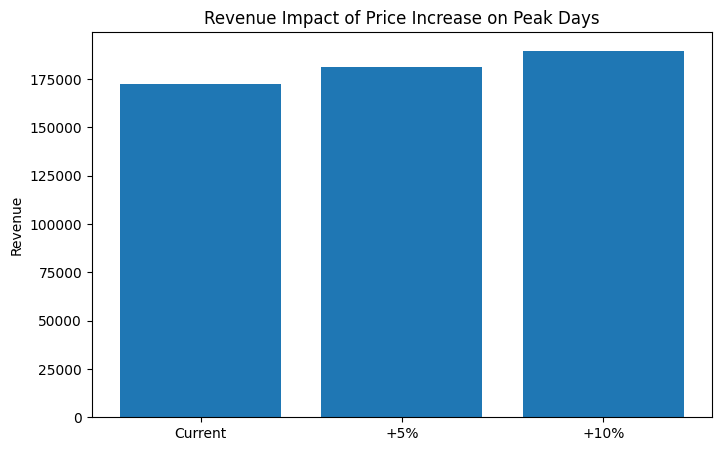

In [173]:
daily_rides = df.groupby('Departure Date')['Transaction ID'].count().reset_index()
daily_rides.rename(columns={'Transaction ID': 'Rides'}, inplace=True)


threshold = daily_rides['Rides'].quantile(0.80)

peak_days = daily_rides[daily_rides['Rides'] >= threshold]

print("Peak Demand Days:")
print(peak_days)

avg_ticket_price = df['Price'].mean()

current_peak_revenue = peak_days['Rides'].sum() * avg_ticket_price

new_peak_revenue_5 = peak_days['Rides'].sum() * (avg_ticket_price * 1.05)

new_peak_revenue_10 = peak_days['Rides'].sum() * (avg_ticket_price * 1.10)

print(f"\nCurrent Peak Revenue: {current_peak_revenue:.2f}")
print(f"Peak Revenue After 5% Increase: {new_peak_revenue_5:.2f}")
print(f"Peak Revenue After 10% Increase: {new_peak_revenue_10:.2f}")


values = [current_peak_revenue, new_peak_revenue_5, new_peak_revenue_10]
labels = ["Current", "+5%", "+10%"]

plt.figure(figsize=(8,5))
plt.bar(labels, values)
plt.title("Revenue Impact of Price Increase on Peak Days")
plt.ylabel("Revenue")
plt.show()



<h1 style="font-size:40px; color:darkblue; text-align:center;"أسئلة تتعلق بفئات التذاكر
(Ticket Classes)
</h1>


# Ticket Class Predictions

### The ticket class expected to have the highest demand next month

In [174]:
class_revenue_share = df.groupby('Ticket Class')['Price'].sum() / df['Price'].sum()

predicted_top_class = class_revenue_share.idxmax()
predicted_top_share = class_revenue_share.max()

print(f"The ticket class expected to have the highest demand next month is '{predicted_top_class}'")
print(f"Expected share of total demand: {predicted_top_share:.2%}")

The ticket class expected to have the highest demand next month is 'Standard'
Expected share of total demand: 79.86%


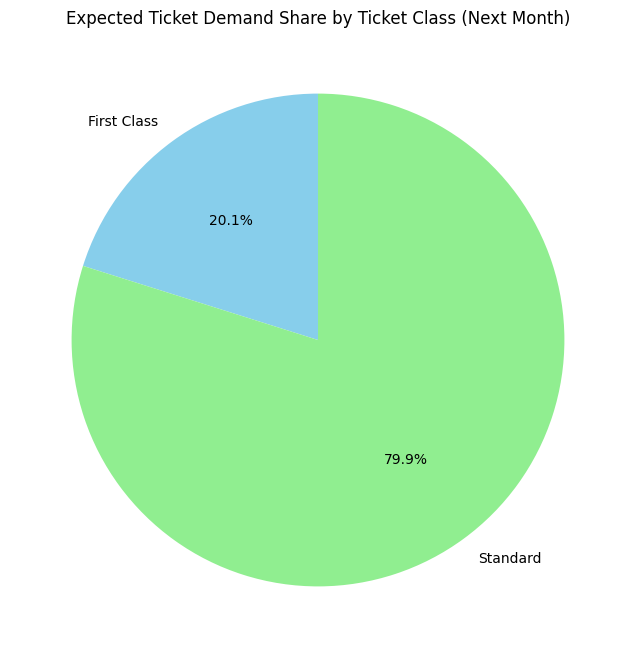

In [175]:
plt.figure(figsize=(8,8))
colors = ['skyblue', 'lightgreen', 'dodgerblue', 'green', 'teal']  # ألوان الأزرق والأخضر
class_revenue_share.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=colors)
plt.title("Expected Ticket Demand Share by Ticket Class (Next Month)")
plt.ylabel("")
plt.show()

### Weekly Ticket Demand by Class 

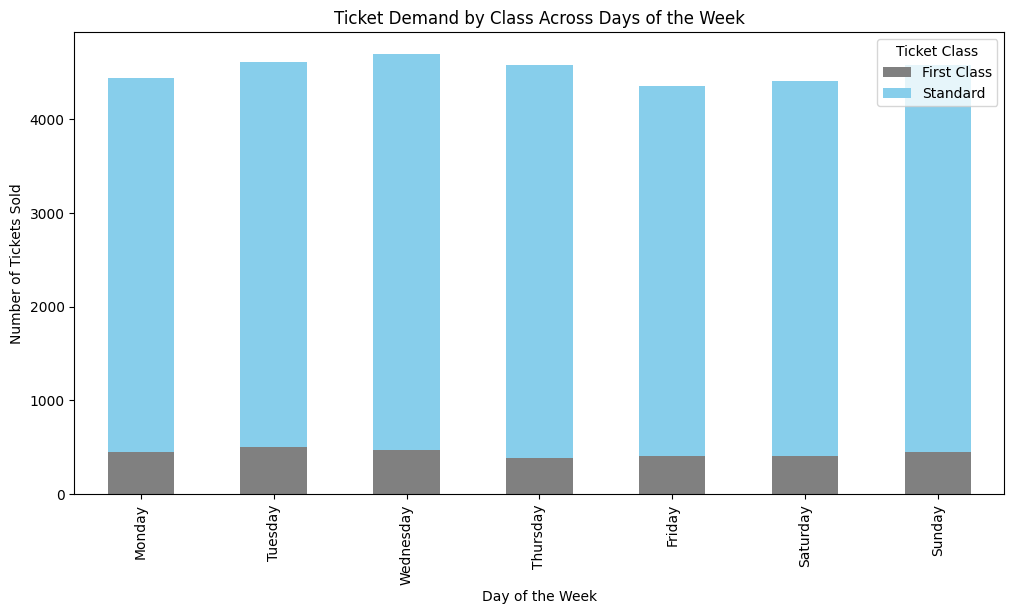

In [176]:
ticket_demand_by_day = df.groupby(['Departure Weekday', 'Ticket Class'])['Transaction ID'].count().unstack()

# ترتيب أيام الأسبوع
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ticket_demand_by_day = ticket_demand_by_day.reindex(days_order)

# رسم stacked bar chart بألوان رمادي ولُبني
colors = ['gray', 'skyblue', 'lightgray', 'lightblue']  # عدّل حسب عدد الفئات لديك
ticket_demand_by_day.plot(kind='bar', stacked=True, figsize=(12,6), color=colors)
plt.title("Ticket Demand by Class Across Days of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Tickets Sold")
plt.legend(title="Ticket Class")
plt.show()

### Impact of 5% Ticket Price Increase on Forecasted Revenue by Ticket Class for the next month

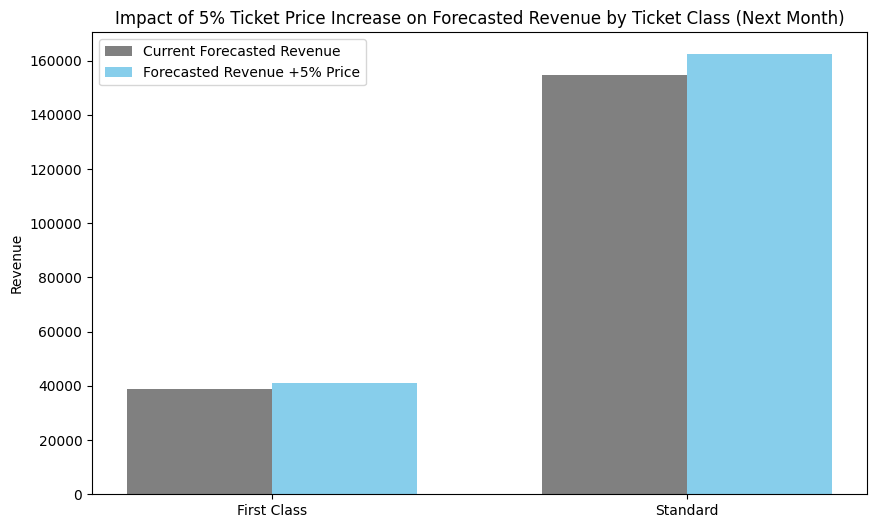

First Class: Current = 38976.72, After 5% Increase = 40925.56, Difference = 1948.84
Standard: Current = 154583.14, After 5% Increase = 162312.29, Difference = 7729.16


In [177]:
forecasted_revenue_by_class = total_predicted_revenue * class_revenue_share

forecasted_revenue_by_class_increased = forecasted_revenue_by_class * 1.05

revenue_diff = forecasted_revenue_by_class_increased - forecasted_revenue_by_class

plt.figure(figsize=(10,6))
bar_width = 0.35
x = range(len(forecasted_revenue_by_class))

plt.bar(x, forecasted_revenue_by_class, width=bar_width, label='Current Forecasted Revenue', color='gray')
plt.bar([i + bar_width for i in x], forecasted_revenue_by_class_increased, width=bar_width, label='Forecasted Revenue +5% Price', color='skyblue')

plt.xticks([i + bar_width/2 for i in x], forecasted_revenue_by_class.index)
plt.ylabel("Revenue")
plt.title("Impact of 5% Ticket Price Increase on Forecasted Revenue by Ticket Class (Next Month)")
plt.legend()
plt.show()

for cls in forecasted_revenue_by_class.index:
    print(f"{cls}: Current = {forecasted_revenue_by_class[cls]:.2f}, After 5% Increase = {forecasted_revenue_by_class_increased[cls]:.2f}, Difference = {revenue_diff[cls]:.2f}")